In [ ]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

#Import Encounters from Database Query
study_cohort_df = pd.read_pickle("cohort_raw.pkl")
admission_df = pd.read_pickle("diagnoses_raw.pkl")
print(study_cohort_df.info())


## Comorbidity-Adjusted Life Expectancy

## Life expectancy
Use the NHVSS 2020 U.S. Life Tables by Sex and Race (Asian, Black, Hispanic, White, General (for AIAN, <1 Race and Unknown). Even though our cohort is entirely composed of NY residents, the NY 2019 Life Tables lack race/ethnicity breakdowns and so were not used. For each individual, the NHVSS life expectancy (i.e. expected remaining years of life) corresponding to their age, sex, and race was applied to their subject record. This generates their _Unadjusted Life Expectancy_.

#### Comorbidity-Adjustment
To account for the effect of comorbidity on long-term life expectancy, we use a simplified version of the menthod established by Cho (2013). For each individual their list of Charlson comorbidities is determined using the ICD-10 codes present upon admission. The overall severity of their comorbidities (none, low, high) is determined by the most severe category in which they have at least one comorbidity. This categorization, alongside sex and limited race info (White, Black, All), is then used to lookup a "health-adjusted age" as determined by Cho (2013) Table 3. We then calculate life expectancy by lookup on the NHVSS table by age, sex, race, and record this as their individual "health-adjusted life expectancy" (note to be confused with population HALE). Cho (2013) only validated their approach for ages 66-90, so we roughly approximate the health-adjusted age for each age less than 66 by applying the difference between age and health-adjusted age (by race, sex and comorbidity group) for age 66 to all ages below 66, i.e. for a 66yr-old white female with no comorbidities, their "health-adjusted age" is 53, and hence all white females with no comorbidities <66 yrs of age had their health-adjusted age calculcated as "age minus 13 yrs".

**Cho (2013)** \
Uses the Charlson index to assign comorbidities to "high", "moderate" and "low" https://www.acpjournals.org/doi/10.7326/0003-4819-159-10-201311190-00005?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed \


### Other Models Considered but not Used.

**Schoenborn (2022)**
Combination of the Cho methodology and a Frailty index to predict life expectancy and 5 and 10 yr mortality.
https://agsjournals.onlinelibrary.wiley.com/doi/full/10.1111/jgs.17468\

    *Comorbidity status was assessed using the method by Cho et al. using a modified Charlson index.1, 32 We excluded diagnoses on outpatient or physician supplier claims that did not appear more than once over time span exceeding 30 days so as to exclude evaluation of suspected diagnoses.33 After the list of comorbidities were identified in claims using diagnosis codes,32 we assigned a weighted score for each condition using the estimated effect of each condition on survival that has been reported previously (e.g., coefficient of each condition on overall survival in the Cox model). 1 The list of conditions and associated weighted scores are included in Table S1. We summed the individual scores of each condition into a total comorbidity score for each 12-month episode of care. We then classified each episode of care into three comorbidity categories based on the total comorbidity score using the cutpoints established by Cho et al: “no comorbidities” (total score = 0), “low/medium comorbidities” (0 < total score ≤ 0.56), and “high comorbidities” (total score > 0.56)*

**Marriotto (2013)**
https://www.sciencedirect.com/science/article/pii/S0895435613002667\

**Van Hemelrijck (2022)**
Much more tentative, but flexible simulation approach to using CCI to adjust life expectancy: https://link.springer.com/article/10.1186/s12911-022-01766-0

In [2]:
#https://github.com/vvcb/comorbidipy/blob/main/docs/usage.md
##Note: MUST comment out the lines referring to "SettingWithCopyWarning" from calculator.py, refers to old pandas distro files
from comorbidipy import comorbidity

dict_race_LE = { #NVSS only provides Hispanic, Black, Asian, White and Overall.
    'Hispanic' : 'Hispanic',
    0: 'General',
    1: 'General',
    2: 'Asian',
    3: 'Black',
    4: 'Asian',
    5: 'White',
    6: 'General',
}

def dict_race_ethnicity (row):
    if row['Ethnicity'] == 1 :
        return 'Hispanic'
    return row['Race']

def dict_sex_LE (row):
    if row['Sex'] == 1 :
        return 'Male'
    return 'Female'

#Comorbidity Weights (coefficients) from Cho 2013, Table 2
Cho_comorbid_weights = pd.DataFrame(list(({
    #      0.105, #History of MI (not in Charlson, could compute by ICD-10)
    'pud': 0.123, #Ulcer
    'ami': 0.247, #Acute MI
    'rheumd': 0.269, #Rheum
    'canc': 0.300, #Cancer (GUESS WEIGHT, NOT IN CHO!!)
    'pvd': 0.367, #PVD
    'diab': 0.372, #Diabetes OR Diabetes w/ complications
    'diabwc': 0.372, #Diabetes OR Diabetes w/ complications
    'hp': 0.394, #Paralysis
    'cevd': 0.420, #Cerebrovascular Disease
    #high 
    'copd': 0.567, #COPD
    'chf': 0.818, #CHF
    'msld': 0.832, #Mod/Sev Liver Disease
    'rend': 0.834, #Chronic Renal Failure
    'dementia': 0.855, #Dementia
    'metacanc': 1.000, #Metastatic Cancer (GUESS WEIGHT, NOT IN CHO!!)
    'mld': 1.035, #Note that this is "Cirrhosis and chronic hepatitis" in Cho, and codes in Charlson are more expansive
    'aids': 1.298  #AIDS
}).items())).rename(columns={0:'Comorbidity', 1:'Cho_weight'})

#Takes ICD-10 data from Admissions and puts in format ready for merging with 
comorbid_cleaner_df = (admission_df
    .merge(study_cohort_df[["Encounter_Number", 'Age_at_Admission']], on="Encounter_Number")
    #.merge(included, on="SubjectID")
    .drop(['seq','Reason_Visit', 'SubjectID', 'dX_Name'], axis=1)
    .rename(columns={"Encounter_Number":"id", "ICD10_dX(s)":"code", "Age_at_Admission":"age"})
    .assign(
        age = lambda df_1: df_1['age']
            .dropna() #ignores rows with NaN as Age_at_Admission (row will stay in df, and generate a NaN for Age)
            .mask(df_1['age'] == '>90', 90) #truncate >90 to integer 90 for comorbidipy processing
            .astype({'age':int}) #truncate ages for comorbidipy and LE processing
        )
    .set_index(['id', 'age']) #set id and age into index, to allow explode to work only on the ICD code column (and hence return age and id for the new rows)
    .apply(lambda df_2: df_2
            .replace(np.nan, 'R69') #fill all encounters with (i) row in admission_df, but (ii) missing ICD10 codes, with R69: Illness, unspecified
            .str.split(',') #split rows that contain two or more ICD10 codes
            .explode() # add rows
            .str.replace('.', '') #remove period from ICD10 codes for processing by comorbidipy
            .str.replace(' ', '') #remove spaces from ICD10 codes for processing by comorbidipy
        )
    .reset_index() #bring id and age out of index.
    .drop_duplicates()
)

print('Number of Unique Encounters Comorbid_Cleaner: ', comorbid_cleaner_df['id'].drop_duplicates().count())
#print('Number of Unique Subjects: ', comorbid_cleaner_df['SubjectID'].drop_duplicates().count())

comorbid_ECI_df = comorbidity(comorbid_cleaner_df,
    #id="Encounter_Number",
    #code='ICD10_dX(s)',
    #age="Age_at_Admission",
    score="elixhauser",
    icd="icd10",
    variant="quan",
    weighting="vw",
    assign0=True,
).rename(columns={"comorbidity_score":"ECI_raw", "age_adj_comorbidity_score":"ECI_age", "id":"Encounter_Number"})

comorbid_CCS_df = (comorbidity(comorbid_cleaner_df,
        #id="Encounter_Number",
        #code='ICD10_dX(s)',
        #age="Age_at_Admission",
        score="charlson",
        icd="icd10",
        variant="quan",
        weighting="quan",
        assign0=True,
        )
    .rename(columns={"comorbidity_score":"CCS_raw", "age_adj_comorbidity_score":"CCS_age", 'id':'Encounter_Number'})
    .sort_values('Encounter_Number')
    .reset_index(drop=True)
)
print('Number of Unique Encounters Comorbid_CCS: ', comorbid_CCS_df['Encounter_Number'].drop_duplicates().count())

comorbid_Cho = (comorbid_CCS_df
    .assign(Cho_Score = lambda df_: (df_
                            .drop(['CCS_raw', 'CCS_age'], axis=1)
                            .melt(id_vars=['Encounter_Number'], var_name='Comorbidity', value_name='Comorbidity_X')
                            .merge(Cho_comorbid_weights, on = 'Comorbidity')
                            .assign(Cho_weight_x = lambda df_a: df_a['Comorbidity_X']*df_a['Cho_weight'])
                            .groupby(['Encounter_Number'])['Cho_weight_x'].sum().values
                       )
               )
    .assign(Cho_Tier = lambda df_1: np.select([df_1['Cho_Score']>0.5, df_1['Cho_Score']>0], ['High', 'Low'], 'None'))
    .reindex(columns=['Encounter_Number', 'Cho_Score', 'Cho_Tier'])
)

#Import NVSS 2020 Life Expectancy by Race and Sex
le_lookup = (pd.read_excel('LE_2020_All.xlsx', sheet_name='All')
    #.set_index(['Age', 'Sex'])
    .melt(id_vars=['Age', 'Sex'], var_name='Race_LE', value_name='Life_Exp', value_vars=['General', 'Hispanic', 'White', 'Asian', 'Black'])
    .assign(Cho_Adj_Age = lambda df_:df_['Age'],
            Cho_LE = lambda df_: df_['Life_Exp'] 
        )
)

#Import Cho (2013) Health Adjusted Ages
Cho_lookup = (pd.read_excel('Cho_2013_Comorbidity_Adjustment.xlsx', sheet_name='Cho_Adjustment')
    .drop(['Cho_Adj_None', 'Cho_Adj_Low', 'Cho_Adj_High'], axis = 1)
    .melt(id_vars=['Age', 'Race_Cho', 'Sex'], var_name='Cho_Tier', value_name='Cho_Adj_Age', value_vars=['Cho_None', 'Cho_Low', 'Cho_High'])
    .assign(Cho_Tier = lambda df_:df_['Cho_Tier'].map({'Cho_None': 'None', 'Cho_Low': 'Low', 'Cho_High': 'High'}))
    .drop_duplicates()
)

#Create Raw and Adj. Life Expectancy per Encounter
encounter_le = (study_cohort_df[['SubjectID', 'Encounter_Number', 'Race', 'Ethnicity', 'Sex', 'Age_at_Admission']]
    #.merge(included)
    .sort_values(by="SubjectID")
    #.set_index("SubjectID")
    .reset_index(drop=True)
    .assign(
        Race_LE = lambda df_1:
            df_1.apply(dict_race_ethnicity, axis=1)
                .map(dict_race_LE),
        Age = lambda df_1:
            df_1['Age_at_Admission']
                .dropna() #drops if with no Age (some subjectID have no age)
                .mask(df_1['Age_at_Admission'] == '>90', 90) #truncate >90 to integer 90 for comorbidipy processing
                .astype(int),
        Sex = lambda df_1:
            df_1.apply(dict_sex_LE, axis=1)
       )
    .merge(le_lookup, on=["Age", "Sex", 'Race_LE'], how="left") #merge in the NVSS 2019 Life Tables for Raw Life expectancy
    .drop(['Cho_LE', 'Cho_Adj_Age'], axis=1) #remove these columns to avoid conflict with Cho_lookup merge
    .merge(comorbid_Cho, on=['Encounter_Number'], how='left') #merge in the Cho Comorbidity Scores and Tiers
    .assign(Race_Cho = lambda df_2: df_2['Race_LE'].map({'White':'White', 'Black':'Black', 'Asian': 'General', 'Hispanic': 'General', 'General': 'General'})) #map the reduce Cho race categories
    .merge(Cho_lookup, on=["Age", "Sex", 'Race_Cho', 'Cho_Tier'], how="left") #merge in the Cho Health Adjusted Ages for each Age, Sex, Race, and Comorbidity Tier
    .merge(le_lookup, on=["Cho_Adj_Age", "Sex", 'Race_LE'], how="left") #merge in the NVSS 2019 Life Tables on the Cho Health Adjusted Ages
    .rename({'Age_x':'Age', 'Life_Exp_x': 'Life_Exp'}, axis=1)
    .drop(['Age_y', 'Life_Exp_y'], axis=1)
    .round(1) #round all numbers to 1 decimal place
)
print(encounter_le.info())
print('Number of Unique Encounters: ', encounter_le['Encounter_Number'].drop_duplicates().count())
print('Number of Unique Subjects: ', encounter_le['SubjectID'].drop_duplicates().count())

Number of Unique Encounters Comorbid_Cleaner:  4594
Number of Unique Encounters Comorbid_CCS:  4594
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4605 entries, 0 to 4604
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SubjectID         4605 non-null   object 
 1   Encounter_Number  4605 non-null   object 
 2   Race              4605 non-null   int64  
 3   Ethnicity         4319 non-null   float64
 4   Sex               4605 non-null   object 
 5   Age_at_Admission  4601 non-null   object 
 6   Race_LE           4605 non-null   object 
 7   Age               4601 non-null   float64
 8   Life_Exp          4601 non-null   float64
 9   Cho_Score         4595 non-null   float64
 10  Cho_Tier          4595 non-null   object 
 11  Race_Cho          4605 non-null   object 
 12  Cho_Adj_Age       4593 non-null   float64
 13  Cho_LE            4593 non-null   float64
dtypes: float64(6), int64(1), object(7)
m

## Comorbidity Indices and SOFA+Comorbidity Protocols


#### Elixhauser
  Mostly used to predict *in-hospital* mortality. Catgeorizes 23 comorbid cnditions and then optionally uses weights (van Walraven, 2009) to create a summary score.
  \
  
  *_References_*
   - See top results here: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C33&q=elixhauser&btnG=\
   - AHRQ (2017) Model - https://journals.lww.com/lww-medicalcare/Fulltext/2017/07000/Identifying_Increased_Risk_of_Readmission_and.9.aspx\
   - Summary-Elixhauser (https://www.acpjournals.org/doi/10.7326/M21-4204)\
   - van-Walraven (2009) weights to create the Elixhauser "score" https://journals.lww.com/lww-medicalcare/Fulltext/2009/06000/A_Modification_of_the_Elixhauser_Comorbidity.4.\aspx 
   - ICD-10 modfication and validation (2017) https://journals.lww.com/lww-medicalcare/Fulltext/2017/12000/Adaptation_and_Validation_of_the_Combined.10.aspx

#### SOFA Bands + Comorbidity, with age as tie-breaker (Maryland)*\
Maryland https://pubmed.ncbi.nlm.nih.gov/30316913/
Is an implementation of the 2017 Maryland CSC (https://bioethicstoday.org/wp-content/uploads/2020/03/Daugherty-Maryland-framework-PH-emergency-2017.pdf)
    Used a comorbidity model where +3 was added to SOFA for "severe" comorbidities understood as Elixhauser scores greater than or equal to the weight identified for metastatic cancer (i.e. <=12)

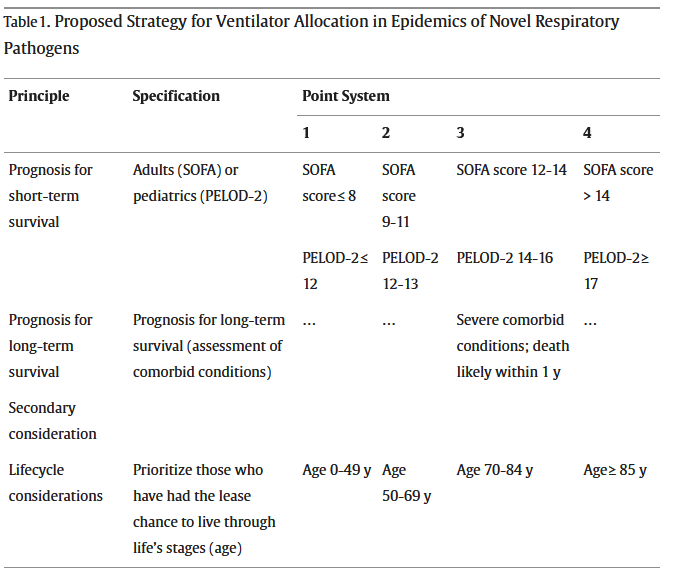

Table from the original van Walraven study - we are using "metacanc" as our van Walraven threshold.

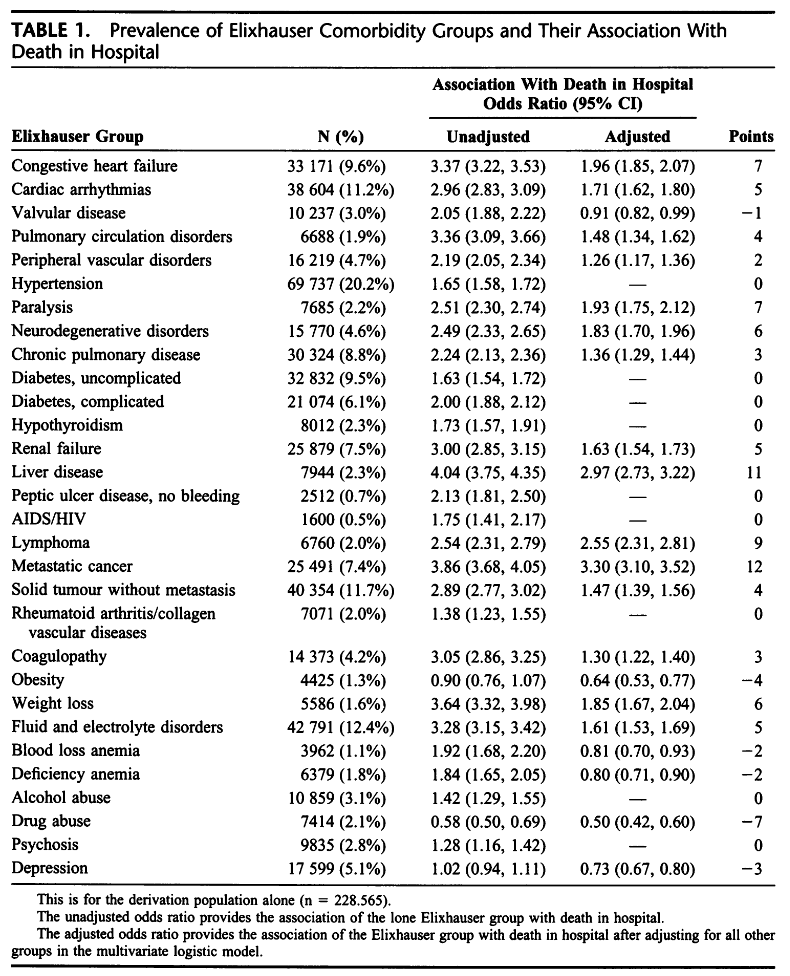

#### SOFA Bands + Comorbidity (PA, White and Lo (NOT USED))\
 (https://jamanetwork.com/journals/jama/fullarticle/2763953)\
 Assigned points based on:\
  | SOFA | SOFA <6 = 1 | SOFA 6-8 = 2| SOFA 9-11 = 3 | SOFA >11 = 4 |\
  | Comorbidity | | Death expected <5 yrs = +2  | | Death expected <1yr = +4 |

  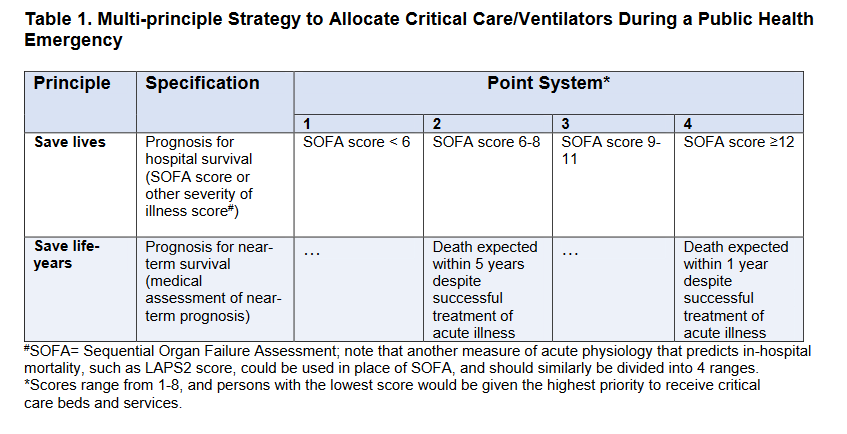

#### SOFA Bands + Combordity and Age (Colorado, 2020) (p100)\
Found here: https://drive.google.com/file/d/1SKT49ps1dxpPsByPr3z0QiISwmqvTUGM/view 
Referenced here: https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2774098
TABLE 1
Purpose Specification Point SystemA
0 1 2 3 4
Measure of Acute
Illness
Adjusted SOFA
score B
X 1-5 6-9 10-12 >12
Measure of chronic
illness
Modified Charlson
Comorbidity Index
Score C
0 1-2 3-5 6-7 >8

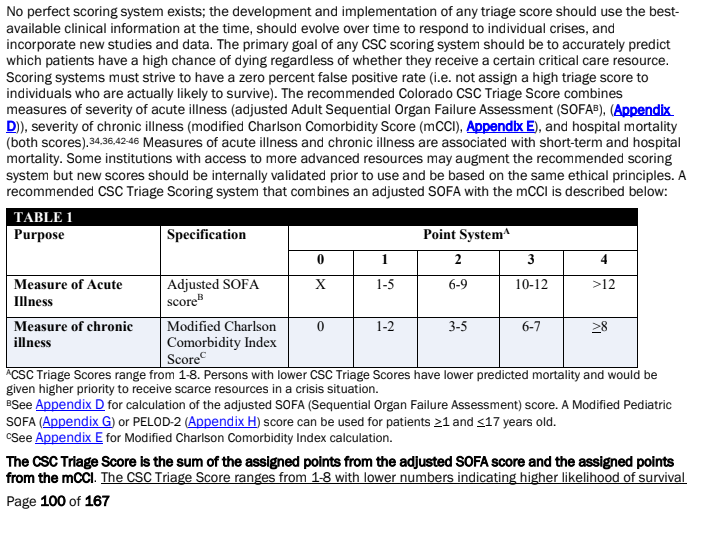

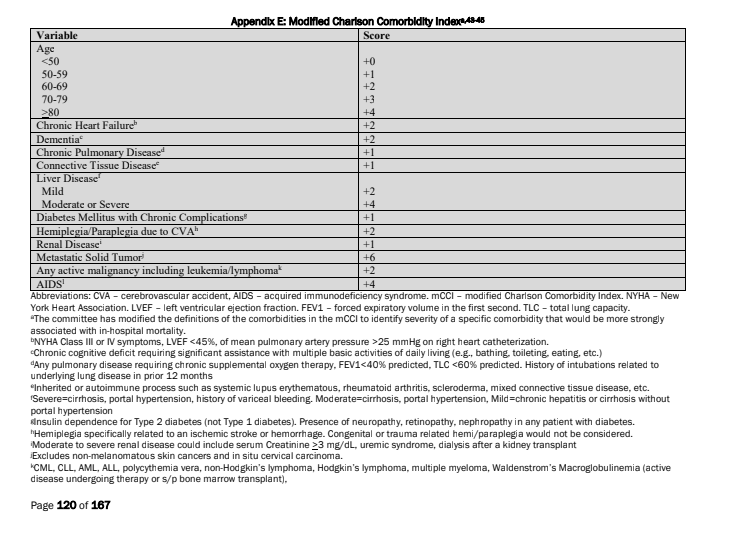


In [ ]:
def Maryland_comorbid_cat(row): #See Table S2 from the IMRS study linked in Maryland
    if row['ECI_raw'] >= 12: 
        return +3 #Severe (3rd tertile in IMRS study)
    return +0 #Mild and Moderate (1st tertile)

def Maryland_sofa_calc(row) :
    if row['sofa_score'] >14:
        return 4
    elif row['sofa_score'] >=12:
        return 3
    elif row['sofa_score'] >=9:
        return 2
    return 1

#See the Colorado modified Charlson Index
colorado_dict = pd.DataFrame(list(({
    'aids': 4,
    'ami': 0,
    'canc': 2, #Any active malignancy including leukemia/lymphoma
    'cevd': 0,
    'chf': 2,
    'copd': 1,
    'dementia': 2,
    'diab': 0,
    'diabwc': 1, #Diabetes Mellitus with Chronic Complication
    'hp': 2, #Hemiplegia/Paraplegia due to CVA, emiplegia specifically related to an ischemic stroke
                #or hemorrhage. Congenital or trauma related hemi/paraplegia would not be considered.
    'metacanc': 6,
    'mld': 2,
    'mlsd': 4,
    'pud': 0,
    'pvd': 0,
    'rend': 1, #Renal Disease, Moderate to severe renal disease could include serum Creatinine >3 mg/dL, uremic syndrome, dialysis after a kidney transplant
    'rheumd': 1 #Connective Tissue Disease - Inherited or autoimmune process such as systemic lupus erythematous, rheumatoid arthritis, scleroderma, mixed connective tissue disease, etc.
}).items())).rename(columns={0:'Comorbidity', 1:'Colorado_weight'})

def colorado_age_calc(row) :
    if row['age'] >= 80:
        return 4
    elif row['age'] >= 70:
        return 3
    elif row['age'] >= 60:
        return 2
    elif row['age'] >= 50:
        return 1
    return 0

def colorado_comorbid_calc(row) :
    if (row['CCS_Colorado']+row['Colorado_Age']) >7:
        return 4
    elif (row['CCS_Colorado']+row['Colorado_Age']) >5:
        return 3
    elif (row['CCS_Colorado']+row['Colorado_Age']) >2:
        return 2
    elif (row['CCS_Colorado']+row['Colorado_Age']) >0:
        return 1
    return 0

def colorado_sofa_calc(row) :
    if row['sofa_score'] >12:
        return 4
    elif row['sofa_score'] >9:
        return 3
    elif row['sofa_score'] >5:
        return 2
    elif row['sofa_score'] >0:
        return 1
    return 0

def PA_sofa_calc(row) :
    if row['sofa_score'] >11:
        return 4
    elif row['sofa_score'] >8:
        return 3
    elif row['sofa_score'] >5:
        return 2
    return 1

def PA_comorbid_cat(row): #See Table S2 from the IMRS study linked in Maryland
    if row['ECI_raw'] >= 4: 
        return 4 #Severe (3rd tertile of Acute Van Walraven in IMRS study)
    elif row['ECI_raw'] >= 0: #Moderate (2nd tertile of Acute Van Walraven in IMRS Study)
        return 2
    return +0 #Mild (1st tertile)

encounter_comorbid = (comorbid_CCS_df
    .merge(comorbid_ECI_df.reindex(columns=['Encounter_Number', 'ECI_raw']), on="Encounter_Number")
    .assign(Maryland_C = lambda df_: df_.apply(Maryland_comorbid_cat, axis=1),
        PA_C = lambda df_: df_.apply(PA_comorbid_cat, axis=1),
        CCS_Colorado = lambda df_: (df_
            .drop(['CCS_raw', 'CCS_age'], axis=1)
            .melt(id_vars=['Encounter_Number'], var_name='Comorbidity', value_name='Comorbidity_X')
            .merge(colorado_dict, on = 'Comorbidity')
            .assign(Colorado_weight_x = lambda df_a: df_a['Comorbidity_X']*df_a['Colorado_weight'])
            .groupby(['Encounter_Number'])['Colorado_weight_x'].sum().values
            ),
        Colorado_Age = lambda df_: df_.apply(colorado_age_calc, axis=1)
        )
    #.merge((comorbid_cleaner_df[["id", "age"]].rename(columns={"id":"Encounter_Number"})), on="Encounter_Number")
        .assign(Colorado_C = lambda df_: df_.apply(colorado_comorbid_calc, axis=1))
    .rename(columns = {'Encounter_Number':'EncounterID'})
)

#White and Lo / Wunsch 2020 mapping of comorbidity, need finer grained analysis
#SOFA+Comorbid